<a href="https://colab.research.google.com/github/stephanie0620/113_1/blob/main/%E9%87%91%E8%9E%8D%E5%A4%A7%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90/week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 使用 yfinance 抓取股價資料

In [1]:
import yfinance as yf
import pandas as pd

def get_stock_data(stock_id, start_date, end_date):
    '''
    使用 yfinance 抓取股價資料

    參數：
    - stock_id (str): 股票代號
    - start_date (str): 開始日期 (YYYY-MM-DD)
    - end_date (str): 結束日期 (YYYY-MM-DD)

    返回：
    - df (DataFrame): 包含股價資料的 DataFrame
    '''
    df = yf.download(stock_id, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.columns = ['開盤價', '最高價', '最低價', '收盤價', '成交量']
    return df


In [2]:
# 抓取台積電 2024 年的股價
df_org = get_stock_data('2330.TW', '2020-01-01', '2023-01-01')
df_org.head()

[*********************100%***********************]  1 of 1 completed


,開盤價,最高價,最低價,收盤價,成交量
Date,,,,,
2020-01-02 00:00:00+00:00,332.5,339.0,332.5,339.0,31754120
2020-01-03 00:00:00+00:00,344.0,345.0,335.5,339.5,41811268
2020-01-06 00:00:00+00:00,333.0,334.5,332.0,332.0,45343057
2020-01-07 00:00:00+00:00,332.5,333.0,326.5,329.5,50879181
2020-01-08 00:00:00+00:00,325.0,333.0,325.0,329.5,37567748


In [3]:
df = df_org.copy()
df.columns

Index(['開盤價', '最高價', '最低價', '收盤價', '成交量'], dtype='object')

## 作業1：使用 TensorFlow 實作類神經網路模型預測股票價格

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [5]:
# 選擇收盤價作為預測目標
close_prices = df['收盤價']

train_data, test_data = train_test_split(close_prices, test_size=0.2, shuffle=False)

print(f"訓練集長度: {len(train_data)}")
print(f"測試集長度: {len(test_data)}")

訓練集長度: 587
測試集長度: 147


In [6]:
print("Train Data Range:", train_data.min(), train_data.max())
print("Test Data Range:", test_data.min(), test_data.max())


Train Data Range: 248.0 683.0
Test Data Range: 371.0 544.0


In [7]:
def create_tf_ann_model(input_shape):
    # 建立深度學習 ANN 模型
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    # 使用較小的學習率
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='mse')
    return model

def preprocess_data_with_scaling(data, N):
    # 使用 MinMaxScaler 進行正規化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(len(scaled_data) - N):
        X.append(scaled_data[i:i+N])
        y.append(scaled_data[i+N])

    return np.array(X), np.array(y), scaler

def inverse_transform_predictions(predictions, scaler):
    # 將預測值反向縮放回原始價格範圍
    return scaler.inverse_transform(predictions)

def train_and_predict_best_tf_ann(df, train_data, test_data, N=5, epochs=100):
    # 預處理資料並進行正規化
    X_train, y_train, scaler = preprocess_data_with_scaling(train_data, N)
    X_test, y_test, _ = preprocess_data_with_scaling(test_data, N)

    # 建立 ANN 模型
    model = create_tf_ann_model(N)

    # 使用 ModelCheckpoint 回調函數保存最佳模型
    best_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras', monitor='loss', save_best_only=True, mode='min'
    )

    # 訓練模型
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1,
              callbacks=[best_model_checkpoint])

    # 加載最佳模型
    model.load_weights('best_model.keras')

    # 預測結果並反向縮放
    train_predictions = inverse_transform_predictions(model.predict(X_train), scaler)
    test_predictions = inverse_transform_predictions(model.predict(X_test), scaler)

    # 將 y_train 和 y_test 反向縮放，恢復至原始價格範圍
    y_train_actual = inverse_transform_predictions(y_train.reshape(-1, 1), scaler)
    y_test_actual = inverse_transform_predictions(y_test.reshape(-1, 1), scaler)

    # 提取日期索引
    train_dates = df.index[:len(train_data)]
    test_dates = df.index[len(train_data):len(train_data) + len(test_data)]

    # 可視化
    plt.figure(figsize=(14, 7))
    plt.plot(train_dates, train_data, label='Train Actual', color='blue')
    plt.plot(test_dates, test_data, label='Test Actual', color='black')
    plt.plot(train_dates[N:], train_predictions, label='Train Prediction', color='cyan', linestyle='--')
    plt.plot(test_dates[N:], test_predictions, label='Test Prediction', color='red', linestyle='--')

    # 圖表設置
    plt.title('Stock Price Prediction with Best Model - TensorFlow ANN')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.4303
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4283
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4454
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4198
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4052 
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4081
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4109 
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3894 
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3879 
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3688 
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3878
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3746 
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3587
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3723
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

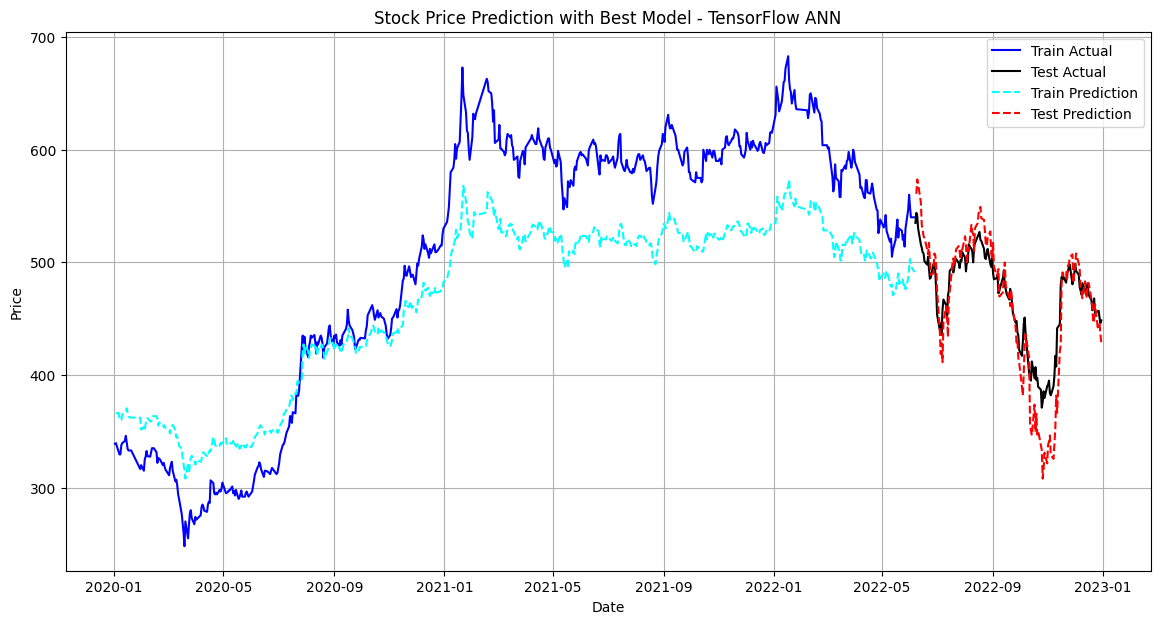

In [8]:
# 使用 TensorFlow 的深度學習模型來預測 3 天後的股價
train_and_predict_best_tf_ann(df, train_data, test_data, N=1, epochs=100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.6376
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5937 
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5937 
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5233 
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4955 
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4571 
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4524 
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4013 
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3841 
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3624 
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3281 
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3318 
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2848 
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2476 
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2490 
E

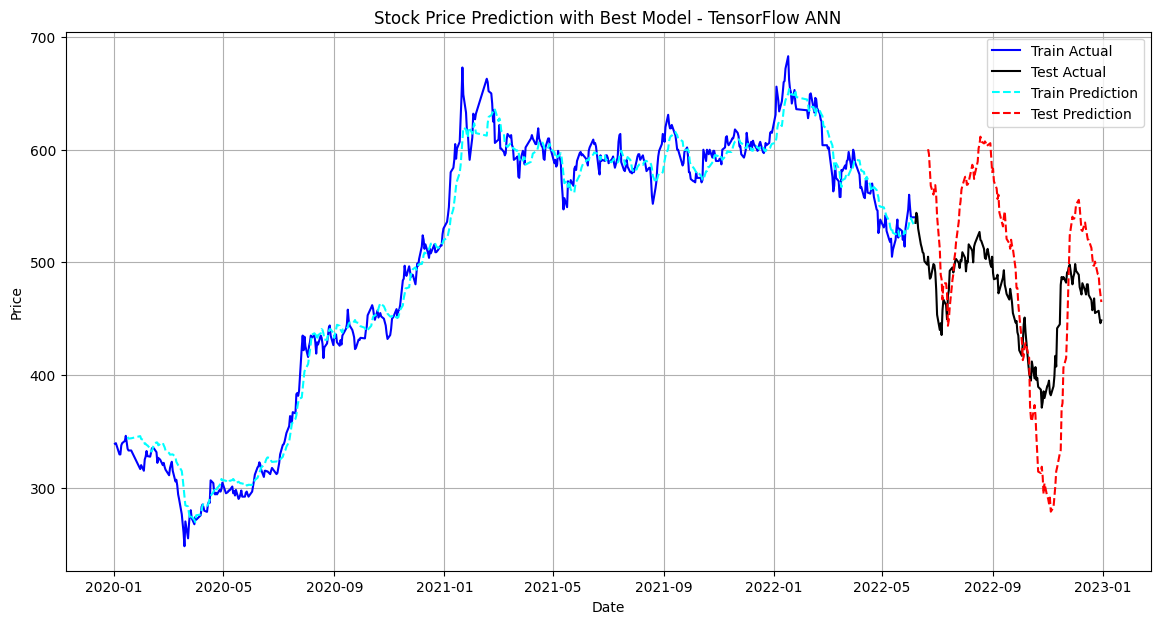

In [9]:
# 使用 TensorFlow 的深度學習模型來預測 10 天後的股價
train_and_predict_best_tf_ann(df, train_data, test_data, N=10, epochs=100)

## 作業2：使用 TensorFlow 實作 CNN 捕捉 K 線趨勢，並預測股價漲跌

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from sklearn.model_selection import train_test_split

In [11]:
# 標記漲跌標籤
def create_labels(df):
    df['5_SMA'] = df['收盤價'].rolling(window=5).mean()
    df['10_SMA'] = df['收盤價'].rolling(window=10).mean()
    df['Label'] = np.where(df['5_SMA'] > df['10_SMA'], 1, 0)  # 5 日均線 > 10 日均線為 1（漲），否則為 0（跌）
    df.dropna(inplace=True)  # 移除 NaN
    return df

# 保存 K 線圖
def save_candlestick_images(df, N=20, train_ratio=0.8, output_dir='candlestick_images'):
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # 分割成訓練和測試資料
    data = [(df.iloc[i-N:i], df.iloc[i]['Label']) for i in range(N, len(df))]
    train_data, test_data = train_test_split(data, train_size=train_ratio, shuffle=False)

    def save_images(data, folder):
        for i, (subset, label) in enumerate(data):
            # 根據標籤創建子資料夾
            label_str = 'up' if label == 1 else 'down'
            label_folder = os.path.join(folder, label_str)
            os.makedirs(label_folder, exist_ok=True)

            # 畫圖並保存圖片
            fig, ax = plt.subplots(figsize=(6, 4))
            for idx, row in subset.iterrows():
                date = mdates.date2num(idx)
                open_price, high, low, close = row['開盤價'], row['最高價'], row['最低價'], row['收盤價']

                color = 'green' if close >= open_price else 'red'

                # K 線圖
                rect = plt.Rectangle((date - 0.2, min(open_price, close)), 0.4, abs(close - open_price), color=color)
                ax.add_patch(rect)
                plt.plot([date, date], [low, high], color=color)

            ax.xaxis_date()
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.xticks(rotation=45)
            plt.axis('off')
            plt.grid(False)

            # 儲存圖片到子資料夾
            plt.savefig(f"{label_folder}/candlestick_{i}.png", bbox_inches='tight', pad_inches=0)
            plt.close(fig)

    # 保存訓練和測試圖片
    save_images(train_data, train_dir)
    save_images(test_data, test_dir)


# CNN 模型建立
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def load_image_data(output_dir='candlestick_images', img_size=(64, 64), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0/255)

    train_data = datagen.flow_from_directory(
        os.path.join(output_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    test_data = datagen.flow_from_directory(
        os.path.join(output_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary'
    )

    return train_data, test_data

def create_cnn_model(input_shape=(64, 64, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 訓練 CNN 模型
def train_cnn_model(output_dir='candlestick_images', img_size=(64, 64), epochs=10):
    train_data, test_data = load_image_data(output_dir=output_dir, img_size=img_size)
    cnn_model = create_cnn_model(input_shape=(img_size[0], img_size[1], 3))

    cnn_model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data
    )

    return cnn_model



In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_cnn_model(model, output_dir='candlestick_images', img_size=(64, 64), batch_size=32):
    # 加載測試數據
    datagen = ImageDataGenerator(rescale=1.0/255)
    test_data = datagen.flow_from_directory(
        os.path.join(output_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # 評估準確率
    loss, accuracy = model.evaluate(test_data)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}")

    # 預測標籤
    test_data.reset()  # 重置生成器的狀態
    predictions = (model.predict(test_data) > 0.5).astype(int).reshape(-1)
    true_labels = test_data.classes  # 真實標籤

    # 分類報告
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=test_data.class_indices.keys()))

    # 混淆矩陣
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(),
                yticklabels=test_data.class_indices.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [12]:
df_k = create_labels(df)
save_candlestick_images(df_k, N=20, train_ratio=0.8, output_dir='candlestick_images')

In [13]:
# 訓練 CNN 模型
cnn_model = train_cnn_model(output_dir='candlestick_images', img_size=(64, 64), epochs=20)

Found 564 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 496ms/step - accuracy: 0.4968 - loss: 0.7179 - val_accuracy: 0.6170 - val_loss: 0.6707
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5642 - loss: 0.6832 - val_accuracy: 0.6241 - val_loss: 0.6274
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.6849 - loss: 0.5772 - val_accuracy: 0.7376 - val_loss: 0.5372
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8135 - loss: 0.4163 - val_accuracy: 0.7092 - val_loss: 0.5198
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8227 - loss: 0.3814 - val_accuracy: 0.8014 - val_loss: 0.4261
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8778 - loss: 0.2928 - val_accuracy: 0.8156 - val_loss: 0.4010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9116 - loss: 0.2503 - val_accuracy: 0.8227 - val_loss: 0.4214
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9100 - loss: 0.2331 - val_accuracy: 0.8156 - val_loss

Found 141 images belonging to 2 classes.
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6875 - loss: 1.8732

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.7788 - loss: 1.0554
Test Loss: 0.7562751770019531
Test Accuracy: 0.8156028389930725
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step

Classification Report:
              precision    recall  f1-score   support

        down       0.92      0.77      0.84        87
          up       0.71      0.89      0.79        54

    accuracy                           0.82       141
   macro avg       0.81      0.83      0.81       141
weighted avg       0.84      0.82      0.82       141



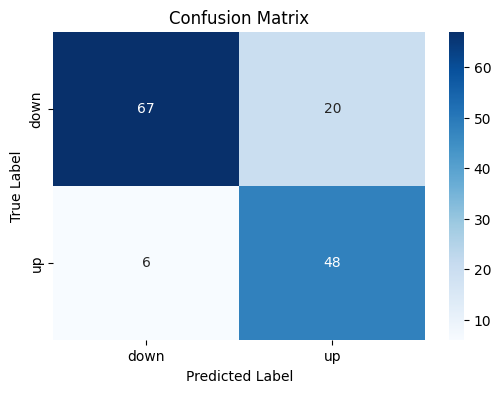

In [16]:
# 評估 CNN 模型
evaluate_cnn_model(cnn_model, output_dir='candlestick_images', img_size=(64, 64), batch_size=32)

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def predict_and_visualize(model, img_path, true_label=None, img_size=(64, 64)):
    # 加載圖片並進行預處理
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # 標準化
    img_array = np.expand_dims(img_array, axis=0)  # 增加批次維度

    # 模型預測
    prediction = model.predict(img_array)
    predicted_label = 'Up' if prediction >= 0.5 else 'Down'

    # 真實標籤的文字表示
    true_label_str = 'Up' if true_label == 1 else 'Down'

    # 輸出真實與預測標籤
    print(f"True Label: {true_label_str}")
    print(f"Predicted Label: {predicted_label}")

    # 可視化
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"True: {true_label_str}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
True Label: Up
Predicted Label: Up


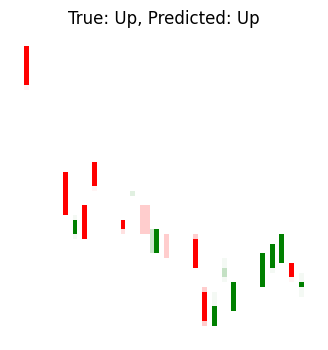

In [19]:
test_img_path = '/content/candlestick_images/test/candlestick_100_up.png'
true_label = 1  # 真實標籤（1: Up，0: Down）
predict_and_visualize(cnn_model, test_img_path, true_label=true_label, img_size=(64, 64))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
True Label: Down
Predicted Label: Up


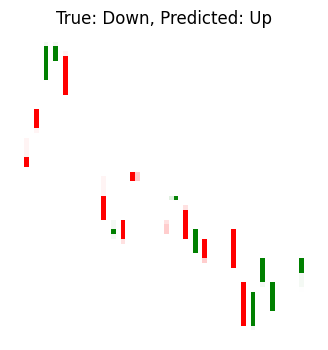

In [32]:
test_img_path = '/content/candlestick_images/test/down/candlestick_97.png'
true_label = 0  # 真實標籤（1: Up，0: Down）
predict_and_visualize(cnn_model, test_img_path, true_label=true_label, img_size=(64, 64))